# **Carregando Pacotes Iniciais e Configurações**

In [84]:
pip install pandas matplotlib seaborn


In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import logging
import sys

# ===================================================================
# --- Configuração Inicial e Importação do Módulo ---
# ===================================================================

# 1. Obter o logger raiz
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# 2. Limpar handlers antigos para evitar logs duplicados
if logger.hasHandlers():
    logger.handlers.clear()

# 3. Criar o formatter
formatter = logging.Formatter('%(asctime)s - [%(levelname)s] - %(message)s')

# 4. Criar o handler para o arquivo
file_handler = logging.FileHandler("analise_cripto.log", mode='w')
file_handler.setFormatter(formatter)

# 5. Criar o handler para o console
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(formatter)

# 6. Adicionar os handlers ao logger
logger.addHandler(file_handler)
logger.addHandler(stream_handler)

sns.set_theme(style="whitegrid")


# Define o caminho para a pasta raiz do seu projeto no Google Drive
caminho_do_projeto = '/content/drive/MyDrive/Trabalho_Final_IA'

# Adiciona o caminho ao sys.path se ele ainda não estiver lá
if caminho_do_projeto not in sys.path:
    sys.path.append(caminho_do_projeto)

try:
    from src.data_load import load_csv_data
    logging.info("Módulo 'data_load' importado com sucesso.")
except ModuleNotFoundError:
    logging.error("ERRO: Módulo 'src.data_load' não encontrado. Verifique a estrutura de pastas e o __init__.py.")
    sys.exit()

# --- Mapeamento e Constantes ---
MAPA_CRIPTOS = {f'dataset{i+1:02d}.csv': cripto for i, cripto in enumerate(
    ['AAVE', 'ADA', 'AERGO', 'AGLD', 'AKITA', 'ALPACA', 'ALPHA', 'APE', 'APX', 'ATLAS']
)}
PASTA_DADOS = '/content/drive/MyDrive/Trabalho_Final_IA/data'
PASTA_GRAFICOS = '/content/drive/MyDrive/Trabalho_Final_IA/figures'
COLUNA_PRECO = 'close'
COLUNA_DATA = 'date'

def analisar_datasets():
    """
    Função principal que orquestra a análise de múltiplos datasets de criptomoedas.
    """
    os.makedirs(PASTA_GRAFICOS, exist_ok=True)
    padrao_arquivos = os.path.join(PASTA_DADOS, 'dataset*.csv')
    lista_arquivos = sorted(glob.glob(padrao_arquivos))

    if not lista_arquivos:
        logging.error(f"Nenhum arquivo encontrado em '{PASTA_DADOS}'.")
        return

    # O restante do código permanece exatamente o mesmo...
    # ... (código das análises a, b, c, d omitido para brevidade, pois não muda) ...
    resultados_dispersao = []

    for caminho_arquivo in lista_arquivos:
        nome_arquivo = os.path.basename(caminho_arquivo)
        nome_cripto = MAPA_CRIPTOS.get(nome_arquivo, nome_arquivo.replace('.csv', ''))

        logging.info(f"--- Iniciando análise para {nome_cripto} ---")

        df = load_csv_data(file_path=caminho_arquivo)

        if df is None:
            continue

        try:
            if COLUNA_PRECO not in df.columns and COLUNA_PRECO.lower() in df.columns:
                df.rename(columns={COLUNA_PRECO.lower(): COLUNA_PRECO}, inplace=True)
            elif COLUNA_PRECO not in df.columns:
                raise KeyError(f"Coluna '{COLUNA_PRECO}' não encontrada.")

            df[COLUNA_DATA] = pd.to_datetime(df[COLUNA_DATA])
            df.set_index(COLUNA_DATA, inplace=True)
            df[COLUNA_PRECO] = pd.to_numeric(df[COLUNA_PRECO], errors='coerce')
            df.dropna(subset=[COLUNA_PRECO], inplace=True)
        except KeyError as e:
            logging.error(f"Erro de processamento em {caminho_arquivo}: {e}")
            logging.info(f"Colunas disponíveis: {df.columns.tolist()}")
            continue

        medidas_resumo = df[COLUNA_PRECO].describe()
        coef_variacao = (medidas_resumo['std'] / medidas_resumo['mean']) * 100 if medidas_resumo['mean'] != 0 else 0

        resultados_dispersao.append({
            'Cripto': nome_cripto,
            'Desvio Padrão (std)': medidas_resumo['std'],
            'Coeficiente de Variação (%)': coef_variacao
        })

        plt.figure(figsize=(10, 5))
        sns.histplot(df[COLUNA_PRECO], kde=True, bins=30)
        plt.title(f'Histograma do Preço de Fechamento - {nome_cripto}')
        plt.savefig(os.path.join(PASTA_GRAFICOS, f'histograma_{nome_cripto}.png'), dpi=300, bbox_inches='tight')
        plt.close()

        plt.figure(figsize=(6, 8))
        sns.boxplot(y=df[COLUNA_PRECO])
        plt.title(f'Boxplot do Preço de Fechamento - {nome_cripto}')
        plt.savefig(os.path.join(PASTA_GRAFICOS, f'boxplot_{nome_cripto}.png'), dpi=300, bbox_inches='tight')
        plt.close()

        media = df[COLUNA_PRECO].mean()
        mediana = df[COLUNA_PRECO].median()
        moda = df[COLUNA_PRECO].mode()[0]

        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df[COLUNA_PRECO], label=f'Preço de Fechamento ({nome_cripto})', alpha=0.8)
        plt.axhline(media, color='red', linestyle='--', label=f'Média: {media:.2f}')
        plt.axhline(mediana, color='green', linestyle='-.', label=f'Mediana: {mediana:.2f}')
        plt.title(f'Série Temporal do Preço de Fechamento - {nome_cripto}', fontsize=16)
        plt.xlabel('Data')
        plt.ylabel('Preço')
        plt.legend()
        plt.figtext(0.5, -0.05, f'Nota: A moda ({moda:.2f}) é calculada, mas não representada por uma linha contínua.', ha='center', fontsize=9)
        plt.savefig(os.path.join(PASTA_GRAFICOS, f'serie_temporal_{nome_cripto}.png'), dpi=300, bbox_inches='tight')
        plt.close()

    logging.info("--- Análises individuais concluídas. Iniciando análise comparativa. ---")

    if resultados_dispersao:
        df_comparativo = pd.DataFrame(resultados_dispersao).sort_values('Coeficiente de Variação (%)', ascending=False)

        print("\n" + "="*70)
        print("c. Análise Comparativa de Variabilidade (Volatilidade Relativa)")
        print("="*70)
        print(df_comparativo.to_string(index=False))

        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='Coeficiente de Variação (%)',
            y='Cripto',
            data=df_comparativo,
            palette='viridis',
            hue='Cripto',
            legend=False
        )
        plt.title('Comparação de Volatilidade Relativa entre Criptomoedas', fontsize=16)
        plt.xlabel('Coeficiente de Variação (%) - Maior significa mais volátil')
        plt.ylabel('Criptomoeda')
        plt.savefig(os.path.join(PASTA_GRAFICOS, 'comparacao_volatilidade.png'), dpi=300, bbox_inches='tight')
        plt.close()

        logging.info(f"Gráfico comparativo de volatilidade salvo em: {PASTA_GRAFICOS}/comparacao_volatilidade.png")

if __name__ == "__main__":
    analisar_datasets()

2025-07-15 07:02:05,230 - [INFO] - Módulo 'data_load' importado com sucesso.
2025-07-15 07:02:05,249 - [INFO] - --- Iniciando análise para AAVE ---
2025-07-15 07:02:05,253 - [INFO] - Carregando dados de '/content/drive/MyDrive/Trabalho_Final_IA/data/dataset01.csv'...
2025-07-15 07:02:11,608 - [INFO] - --- Iniciando análise para dataset010 ---
2025-07-15 07:02:11,614 - [INFO] - Carregando dados de '/content/drive/MyDrive/Trabalho_Final_IA/data/dataset010.csv'...
2025-07-15 07:02:15,693 - [INFO] - --- Iniciando análise para ADA ---
2025-07-15 07:02:15,697 - [INFO] - Carregando dados de '/content/drive/MyDrive/Trabalho_Final_IA/data/dataset02.csv'...
2025-07-15 07:02:21,060 - [INFO] - --- Iniciando análise para AERGO ---
2025-07-15 07:02:21,071 - [INFO] - Carregando dados de '/content/drive/MyDrive/Trabalho_Final_IA/data/dataset03.csv'...
2025-07-15 07:02:27,545 - [INFO] - --- Iniciando análise para AGLD ---
2025-07-15 07:02:27,553 - [INFO] - Carregando dados de '/content/drive/MyDrive/Tr

In [ ]:
!python /content/drive/MyDrive/Trabalho_Final_IA/main.py --crypto AERGO --model RandomForest

In [89]:
pip install pytest pytest-cov

In [90]:
from google.colab import drive
import os

# 1. Montar o Google Drive
print("Montando o Google Drive...")
drive.mount('/content/drive', force_remount=True)

# 2. Definir o caminho raiz do seu projeto
project_root = "/content/drive/MyDrive/Trabalho_Final_IA"
print(f"Raiz do projeto: {project_root}")

# 3. Criar a estrutura de pastas para os testes
tests_dir = os.path.join(project_root, 'tests')
os.makedirs(tests_dir, exist_ok=True)
print(f"Pasta de testes '{tests_dir}' pronta.")

# 4. Criar o arquivo __init__.py na pasta de testes
!touch "{tests_dir}/__init__.py"

# --- 5. Criar os arquivos de teste com Python padrão ---

# 5.1 Conteúdo para o arquivo test_data_load.py
test_data_load_content = """
import pytest
import pandas as pd
import sys
# Adiciona o caminho do projeto para que o 'from src...' funcione
sys.path.insert(0, '/content/drive/MyDrive/Trabalho_Final_IA')
from src.data_load import load_csv_data

def test_load_csv_data_success(tmp_path):
    file_path = tmp_path / "test_data.csv"
    df_original = pd.DataFrame({'col1': [10], 'col2': ['X']})
    df_original.to_csv(file_path, index=False)
    df_loaded = load_csv_data(file_path)
    assert df_loaded is not None
    pd.testing.assert_frame_equal(df_original, df_loaded)

def test_load_csv_data_file_not_found():
    assert load_csv_data("caminho/invalido/arquivo.csv") is None
"""

# 5.2 Conteúdo para o arquivo test_model_trainer.py
test_model_trainer_content = """
import pytest
import pandas as pd
import sys
# Adiciona o caminho do projeto para que o 'from src...' funcione
sys.path.insert(0, '/content/drive/MyDrive/Trabalho_Final_IA')
from src.model_trainer import train_and_evaluate

@pytest.fixture
def sample_dataframe():
    return pd.DataFrame({'close': range(100, 200)})

def test_train_and_evaluate_successful_run(sample_dataframe):
    rmse = train_and_evaluate(df=sample_dataframe, model_name='LinearRegression', n_splits=3, target_col='close')
    assert isinstance(rmse, float) and rmse > 0

def test_train_and_evaluate_invalid_column(sample_dataframe):
    assert train_and_evaluate(df=sample_dataframe, model_name='RandomForest', n_splits=3, target_col='ColunaInvalida') is None

def test_train_and_evaluate_unsupported_model(sample_dataframe):
    with pytest.raises(ValueError, match="Modelo 'MeuModeloRuim' não é suportado."):
        train_and_evaluate(df=sample_dataframe, model_name='MeuModeloRuim', n_splits=3, target_col='close')
"""

# 5.3 Escrevendo os arquivos no disco
path_test_data_load = os.path.join(tests_dir, "test_data_load.py")
with open(path_test_data_load, "w") as f:
    f.write(test_data_load_content)
print(f"Arquivo de teste '{path_test_data_load}' criado.")

path_test_model_trainer = os.path.join(tests_dir, "test_model_trainer.py")
with open(path_test_model_trainer, "w") as f:
    f.write(test_model_trainer_content)
print(f"Arquivo de teste '{path_test_model_trainer}' criado.")

print("\n>>> Estrutura de testes criada com sucesso usando Python padrão! <<<")

Montando o Google Drive...
Mounted at /content/drive
Raiz do projeto: /content/drive/MyDrive/Trabalho Final IA
Pasta de testes '/content/drive/MyDrive/Trabalho Final IA/tests' pronta.
Arquivo de teste '/content/drive/MyDrive/Trabalho Final IA/tests/test_data_load.py' criado.
Arquivo de teste '/content/drive/MyDrive/Trabalho Final IA/tests/test_model_trainer.py' criado.

>>> Estrutura de testes criada com sucesso usando Python padrão! <<<


In [92]:
%cd /content/drive/MyDrive/Trabalho_Final_IA
!pytest --cov=src --cov-report=term-missing

/content/drive/MyDrive/Trabalho_Final_IA
============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0
rootdir: /content/drive/MyDrive/Trabalho_Final_IA
plugins: cov-6.2.1, typeguard-4.4.4, anyio-4.9.0, langsmith-0.4.4
collected 5 items                                                              

tests/test_data_load.py ..                                               [ 40%]
tests/test_model_trainer.py ...                                          [100%]

================================ tests coverage ================================
_______________ coverage: platform linux, python 3.11.13-final-0 _______________

Name                    Stmts   Miss  Cover   Missing
-----------------------------------------------------
src/__init__.py             0      0   100%
src/data_load.py           10      0   100%
src/features.py            22     22     0%   1-45
src/logging_config.py       4      4     0%   1-1

# Realiza K-Fold na moeda ADA com modelo de Regressão Linear

In [93]:
!python /content/drive/MyDrive/Trabalho Final IA/main.py --crypto ADA --kfolds 200 --model LinearRegression

python3: can't open file '/content/drive/MyDrive/Trabalho': [Errno 2] No such file or directory


In [94]:
import pandas as pd
import requests
import logging

# --- Configuração ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - [%(levelname)s] - %(message)s')

COLUNA_DATA_CRIPTOS = 'date'
COLUNA_PRECO_CRIPTOS = 'close'
CAMINHO_CRIPTOS = '/content/drive/MyDrive/Trabalho_Final_IA/data/dataset01.csv'

def buscar_cotacao_dolar(data_inicio: str, data_fim: str) -> pd.DataFrame:
    """Busca a cotação diária do dólar (venda) no Banco Central do Brasil."""
    logging.info(f"Buscando cotação do dólar de {data_inicio} até {data_fim}...")
    url_bcb = (
        "https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo"
        f"(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?"
        f"@dataInicial='{data_inicio}'&@dataFinalCotacao='{data_fim}'&$top=10000&$format=json"
    )
    try:
        response = requests.get(url_bcb)
        response.raise_for_status()
        df_dolar = pd.DataFrame(response.json()['value'])
        df_dolar = df_dolar[['dataHoraCotacao', 'cotacaoVenda']]
        df_dolar.rename(columns={'dataHoraCotacao': 'Date', 'cotacaoVenda': 'Taxa_Cambio'}, inplace=True)
        df_dolar['Date'] = pd.to_datetime(df_dolar['Date']).dt.date
        df_dolar['Taxa_Cambio'] = pd.to_numeric(df_dolar['Taxa_Cambio'])
        logging.info("Cotação do dólar obtida com sucesso.")
        return df_dolar
    except requests.exceptions.RequestException as e:
        logging.error(f"Erro na API do BCB: {e}")
        return None

# --- SCRIPT PRINCIPAL ---
try:

    # Adicionado o parâmetro nrows=20 para ler apenas as primeiras 20 linhas de dados
    df_cripto = pd.read_csv(CAMINHO_CRIPTOS, nrows=20)
    logging.info(f"Arquivo '{CAMINHO_CRIPTOS}' carregado com um limite de 20 linhas.")

    colunas_necessarias = [COLUNA_DATA_CRIPTOS, COLUNA_PRECO_CRIPTOS]
    if not all(coluna in df_cripto.columns for coluna in colunas_necessarias):
        logging.error("Uma ou mais colunas configuradas não foram encontradas no arquivo CSV.")
        logging.error(f"Colunas necessárias: {colunas_necessarias}")
        logging.error(f"Colunas encontradas no arquivo: {df_cripto.columns.tolist()}")
    else:
        df_cripto.rename(columns={
            COLUNA_DATA_CRIPTOS: 'Date',
            COLUNA_PRECO_CRIPTOS: 'Close'
        }, inplace=True)

        df_cripto['Date'] = pd.to_datetime(df_cripto['Date']).dt.date
        data_min, data_max = df_cripto['Date'].min(), df_cripto['Date'].max()
        data_inicio_api = data_min.strftime('%m-%d-%Y')
        data_fim_api = data_max.strftime('%m-%d-%Y')

        df_dolar = buscar_cotacao_dolar(data_inicio_api, data_fim_api)

        if df_dolar is not None:
            df_final = pd.merge(df_cripto, df_dolar, on='Date', how='left')
            df_final['Taxa_Cambio'] = df_final['Taxa_Cambio'].ffill()
            df_final.dropna(inplace=True)
            df_final['Close_BRL'] = df_final['Close'] * df_final['Taxa_Cambio']

            print("\n--- DataFrame Final com as Novas Features (Amostra de 20 Linhas) ---")
            print(df_final[['Date', 'Close', 'Taxa_Cambio', 'Close_BRL']])
        else:
            logging.error("Não foi possível obter a cotação do dólar.")

except FileNotFoundError:
    logging.error(f"Arquivo não encontrado em: {CAMINHO_CRIPTOS}")

2025-07-15 07:06:31,199 - [INFO] - Arquivo '/content/drive/MyDrive/Trabalho_Final_IA/data/dataset01.csv' carregado com um limite de 20 linhas.
2025-07-15 07:06:31,203 - [INFO] - Buscando cotação do dólar de 06-11-2025 até 06-30-2025...
2025-07-15 07:06:31,783 - [INFO] - Cotação do dólar obtida com sucesso.

--- DataFrame Final com as Novas Features (Amostra de 20 Linhas) ---
          Date     Close  Taxa_Cambio  Close_BRL
0   2025-06-30  0.002398       5.4571   0.013086
1   2025-06-29  0.002398       5.4571   0.013086
2   2025-06-28  0.002398       5.4571   0.013086
3   2025-06-27  0.002398       5.4759   0.013131
4   2025-06-26  0.002398       5.5145   0.013224
5   2025-06-25  0.002460       5.5427   0.013635
6   2025-06-24  0.002185       5.4938   0.012004
7   2025-06-23  0.002185       5.5213   0.012064
8   2025-06-22  0.002185       5.5213   0.012064
9   2025-06-21  0.002271       5.5213   0.012539
10  2025-06-20  0.002309       5.4957   0.012690
11  2025-06-19  0.002595       5.4

# **`Etapa de Treinamento - Modelo Polinomial e Linear Regression`**

Etapa de ajuste de modelo linear e modelo polinomial do 2º ao 10º grau.

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import logging

def train_and_fit_model(df: pd.DataFrame, model_name: str, target_col: str, alpha: int = 1):
    """
    Prepara os dados, treina um modelo com TODOS os dados disponíveis e retorna o modelo treinado.

    Args:
        df (pd.DataFrame): O DataFrame de entrada. Deve conter a coluna alvo e, opcionalmente, uma coluna 'Date'.
        model_name (str): O nome do modelo a ser treinado ('LinearRegression', 'RandomForest', 'SVR').
        target_col (str): O nome da coluna que será usada como alvo e feature.

    Returns:
        tuple: Uma tupla contendo (modelo_treinado, X, y) ou (None, None, None) em caso de erro.
               - modelo_treinado: O objeto do modelo sklearn treinado.
               - X: O DataFrame de features usado para o treino.
               - y: A Series do alvo usada para o treino.
    """
    logging.info(f"Iniciando preparação de dados para o treino final. Coluna alvo: '{target_col}'")

    try:
        # --- LÓGICA DE PREPARAÇÃO DE DADOS ---
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.sort_values(by='Date', inplace=True)
            df.reset_index(drop=True, inplace=True)

        dados = df[[target_col]].copy()
        dados['Target'] = dados[target_col]
        dados.dropna(inplace=True)

        if dados.empty:
            logging.error("DataFrame ficou vazio após preparação. Não é possível treinar.")
            return None, None, None

        X = dados[[target_col]]
        y = dados['Target']

    except KeyError:
        logging.error(f"ERRO: A coluna alvo '{target_col}' não foi encontrada no DataFrame.")
        return None, None, None
    except Exception as e:
        logging.error(f"Ocorreu um erro inesperado durante a preparação dos dados: {e}")
        return None, None, None

    # --- SELEÇÃO E TREINAMENTO FINAL DO MODELO ---
    logging.info(f"Treinando o modelo '{model_name}' em {len(X)} amostras de dados.")

    if model_name == 'LinearRegression':
        model = LinearRegression()
        model.fit(X, y)
    elif model_name == 'SVR':
        model = SVR(kernel='poly', degree=alpha, C=1.0, epsilon=0.1, coef0=1)
        model.fit(X, y)
    else:
        logging.error(f"Modelo '{model_name}' não é suportado.")
        raise ValueError(f"Modelo '{model_name}' não é suportado.")

    logging.info("Treinamento finalizado com sucesso!")

    # Retornamos o modelo treinado e os dados usados, para referência
    return model, X, y

Preparação para uso na Predição

In [97]:
CSV_PATH = "/content/drive/MyDrive/Trabalho_Final_IA/data/dataset01.csv"
df = pd.read_csv(CSV_PATH)
modelo_lm, X_lm, y_lm = train_and_fit_model(df, model_name = "LinearRegression", target_col = "close")

polynomial_model = {}
for ia in range(2, 11):
    modelo, X_a, y_a = train_and_fit_model(df, model_name = "SVR", target_col = "close", alpha=ia)
    if "X" not in polynomial_model:
        polynomial_model["X"] = X_a
    if "y" not in polynomial_model:
        polynomial_model["y"] = y_a
    polynomial_model["modelo_"+str(ia)] = modelo


2025-07-15 07:06:57,072 - [INFO] - Iniciando preparação de dados para o treino final. Coluna alvo: 'close'
2025-07-15 07:06:57,077 - [INFO] - Treinando o modelo 'LinearRegression' em 1725 amostras de dados.
2025-07-15 07:06:57,082 - [INFO] - Treinamento finalizado com sucesso!
2025-07-15 07:06:57,084 - [INFO] - Iniciando preparação de dados para o treino final. Coluna alvo: 'close'
2025-07-15 07:06:57,088 - [INFO] - Treinando o modelo 'SVR' em 1725 amostras de dados.
2025-07-15 07:06:57,098 - [INFO] - Treinamento finalizado com sucesso!
2025-07-15 07:06:57,099 - [INFO] - Iniciando preparação de dados para o treino final. Coluna alvo: 'close'
2025-07-15 07:06:57,104 - [INFO] - Treinando o modelo 'SVR' em 1725 amostras de dados.
2025-07-15 07:06:57,109 - [INFO] - Treinamento finalizado com sucesso!
2025-07-15 07:06:57,110 - [INFO] - Iniciando preparação de dados para o treino final. Coluna alvo: 'close'
2025-07-15 07:06:57,115 - [INFO] - Treinando o modelo 'SVR' em 1725 amostras de dados

# Abordagem com Redes Neurais

Utilizou-se a biblioteca Keras para prever a mesma moeda, utilizando duas camadas:

* Primeira Camada: 256 neurônios Relu
* Segunda Camada: 128 neurônios Relu

Foi utilizado dropout de 10% em cada camada.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pdb


def load_dataframe(path: str) -> pd.DataFrame:
    """Load CSV into a DataFrame and ensure proper dtypes."""
    df = pd.read_csv(path)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df = df.sort_values(DATE_COL).reset_index(drop=True)
    return df


def engineer_features(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """Create forward return target and lagged features."""
    # Forward return (next candle)
    df[TARGET] = df["close"]

    # Base feature columns (feel free to tweak)
    base_cols = ["open", "high", "low", "close",
                 "Volume AAVE", "Volume BTC",
                 "buyTakerAmount", "buyTakerQuantity",
                 "tradeCount"]

    # Generate lagged versions
    for col in base_cols:
        for lag in range(1, n_lags + 1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Drop original timestamp / non‑numeric columns
    drop_cols = ["unix", "symbol", "weightedAverage"] + base_cols
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

    # Remove rows with NaN arising from diff/shift
    df = df.dropna().reset_index(drop=True)
    return df


def temporal_split(X: pd.DataFrame, y: pd.Series,
                   train_frac: float, val_frac: float):
    """Deterministic split respecting temporal order."""
    n = len(X)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))
    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test


def scale_features(X_train, X_val, X_test):
    """Standardize features (zero mean, unit variance)"""
    scaler = StandardScaler()
    X_train = X_train.drop("date", axis=1)
    X_val = X_val.drop("date", axis=1)
    X_test = X_test.drop("date", axis=1)
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)
    X_test_s = scaler.transform(X_test)
    return X_train_s, X_val_s, X_test_s, scaler


def build_model(input_dim: int) -> keras.Model:
    """Construct a simple feed‑forward network for regression."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1)  # regression output
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model


CSV_PATH = "/content/drive/MyDrive/Trabalho Final IA/data/dataset01.csv"
DATE_COL = "date"  # name of the datetime column
TARGET = "fechamento"  # engineered below
TRAIN_FRAC = 0.70  # fraction for training set
VAL_FRAC = 0.15  # fraction for validation set
N_LAGS = 3  # number of lagged candles to use as features
BATCH_SIZE = 100
EPOCHS = 500
LEARNING_RATE = 1e-3

print("Loading data ...")
df = load_dataframe(CSV_PATH)
print("Rows before feature engineering:", len(df))

print("Engineering features ...")
df = engineer_features(df, N_LAGS)
print("Rows after feature engineering:", len(df))

# Separate features / target
y = df.pop(TARGET)
X = df

# Temporal split
X_train, y_train, X_val, y_val, X_test, y_test = temporal_split(X, y, TRAIN_FRAC, VAL_FRAC)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Scaling
X_tr_s, X_val_s, X_te_s, scaler = scale_features(X_train, X_val, X_test)

# Build & train model
model = build_model(input_dim=X_tr_s.shape[1])
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=100, restore_best_weights=True
)

print("Training model ...")
history = model.fit(
    X_tr_s, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_s, y_val),
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
print("Evaluating on test set ...")
loss, rmse = model.evaluate(X_te_s, y_test, verbose=0)
y_pred = model.predict(X_te_s).flatten()
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.6f} | R^2: {r2:.4f}")


Loading data ...
Rows before feature engineering: 1725
Engineering features ...
Rows after feature engineering: 1722
Train: 1205, Val: 258, Test: 259
Training model ...
Epoch 1/500
13/13 - 2s - 131ms/step - loss: 0.0357 - rmse: 0.1890 - val_loss: 0.0012 - val_rmse: 0.0347
Epoch 2/500
13/13 - 1s - 44ms/step - loss: 0.0176 - rmse: 0.1327 - val_loss: 0.0051 - val_rmse: 0.0717
Epoch 3/500
13/13 - 0s - 36ms/step - loss: 0.0075 - rmse: 0.0866 - val_loss: 9.4259e-04 - val_rmse: 0.0307
Epoch 4/500
13/13 - 1s - 47ms/step - loss: 0.0042 - rmse: 0.0652 - val_loss: 1.2002e-04 - val_rmse: 0.0110
Epoch 5/500
13/13 - 1s - 53ms/step - loss: 0.0036 - rmse: 0.0601 - val_loss: 3.3962e-04 - val_rmse: 0.0184
Epoch 6/500
13/13 - 0s - 37ms/step - loss: 0.0027 - rmse: 0.0521 - val_loss: 1.7752e-04 - val_rmse: 0.0133
Epoch 7/500
13/13 - 1s - 44ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 1.6830e-05 - val_rmse: 0.0041
Epoch 8/500
13/13 - 0s - 23ms/step - loss: 0.0016 - rmse: 0.0404 - val_loss: 1.7686e-05 -

Para algumas simulações o modelo com MLP chegou a obter $R^2$ de 80%.

# **Verificação de Overfitting e Ajuste**

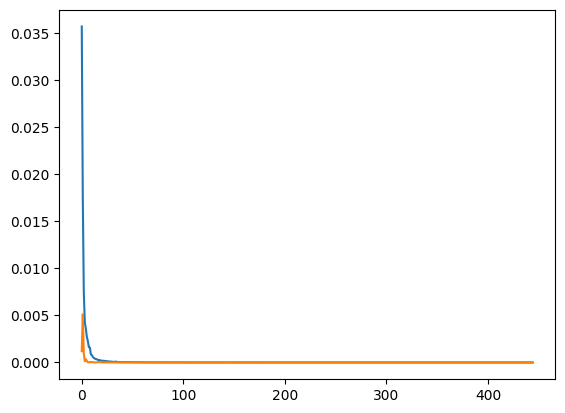

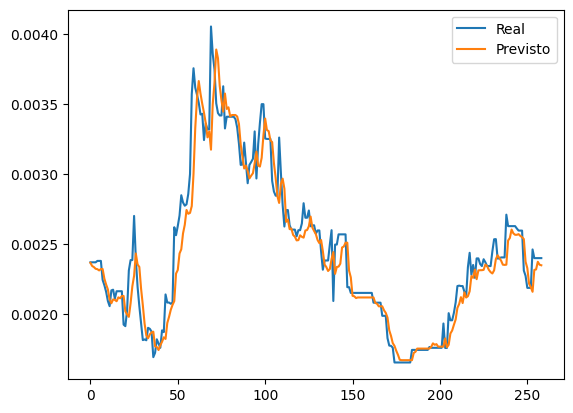

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(history.history['loss'],     label='Treino')
plt.plot(history.history['val_loss'], label='Validação')

y_pred = model.predict(X_te_s, verbose=0)
plt.figure(2)
plt.plot(y_test.to_list(), label='Real')
plt.plot(y_pred, label='Previsto')
plt.legend()
plt.show()

# **Verificação de Backtest e Lucro com modelos**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def backtest_and_compare(
    df: pd.DataFrame,
    price_col: str,
    mlp_pred_col: str,
    regr_pred_cols: dict,
    init_capital: float = 1_000.0,
) -> dict:
    def run_strategy(real, pred):
        equity = [init_capital]
        for t in range(len(real) - 1):
            if pred[t] > real[t]:
                equity.append(equity[-1] * (real[t + 1] / real[t]))
            else:
                equity.append(equity[-1])
        return equity

    real_prices = df[price_col].values
    mlp_pred    = df[mlp_pred_col].values

    metrics = {}
    metrics["MLP"] = {
        "equity_curve": run_strategy(real_prices, mlp_pred),
        "rmse": np.sqrt(mean_squared_error(real_prices[1:], mlp_pred[:-1])),
    }

    best_equity, best_name = -np.inf, None
    for name, col in regr_pred_cols.items():
        pred = df[col].values
        equity_curve = run_strategy(real_prices, pred)
        rmse = np.sqrt(mean_squared_error(real_prices[1:], pred[:-1]))
        metrics[name] = {"equity_curve": equity_curve, "rmse": rmse}
        if equity_curve[-1] > best_equity:
            best_equity, best_name = equity_curve[-1], name

    metrics["best_regr"] = best_name

    # Gráfico de dispersão
    plt.figure(figsize=(7, 5))
    plt.scatter(real_prices[1:], mlp_pred[:-1], alpha=0.5, label="MLP")
    for name, col in regr_pred_cols.items():
        plt.scatter(real_prices[1:], df[col].values[:-1], alpha=0.4, label=name)
    plt.xlabel("Preço real (t+1)")
    plt.ylabel("Previsão (t+1)")
    plt.legend()
    plt.title("Dispersão das previsões — MLP vs Regressões")
    plt.tight_layout()
    plt.show()

    # Correlação
    corr = {
        m: np.corrcoef(real_prices[1:], df[c].values[:-1])[0, 1]
        for m, c in {**{ "MLP": mlp_pred_col }, **regr_pred_cols}.items()
    }
    metrics["correlation"] = corr

    # Polinômio ótimo
    best_deg, best_se = None, np.inf
    for deg in range(2, 11):
        poly = PolynomialFeatures(deg, include_bias=False)
        X = poly.fit_transform(real_prices[:-1].reshape(-1, 1))
        y = real_prices[1:]
        reg = LinearRegression().fit(X, y)
        yhat = reg.predict(X)
        se = np.sqrt(mean_squared_error(y, yhat))
        if se < best_se:
            best_se, best_deg = se, deg
    metrics["poly_best_deg"] = best_deg
    metrics["poly_best_stderr"] = best_se

    # Erro padrão entre MLP e melhor regressão
    best_preds = df[regr_pred_cols[best_name]].values[:-1]
    stderr_between = np.sqrt(np.mean((mlp_pred[:-1] - best_preds) ** 2))
    metrics["stderr_MLP_vs_best"] = stderr_between

    # Gráfico f: evolução do lucro
    plt.figure(figsize=(8, 5))
    for name in ["MLP"] + list(regr_pred_cols.keys()):
        curve = metrics[name]["equity_curve"]
        plt.plot(curve, label=name)
    plt.xlabel("Dias")
    plt.ylabel("Capital acumulado (USD)")
    plt.title("Evolução do lucro acumulado por modelo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


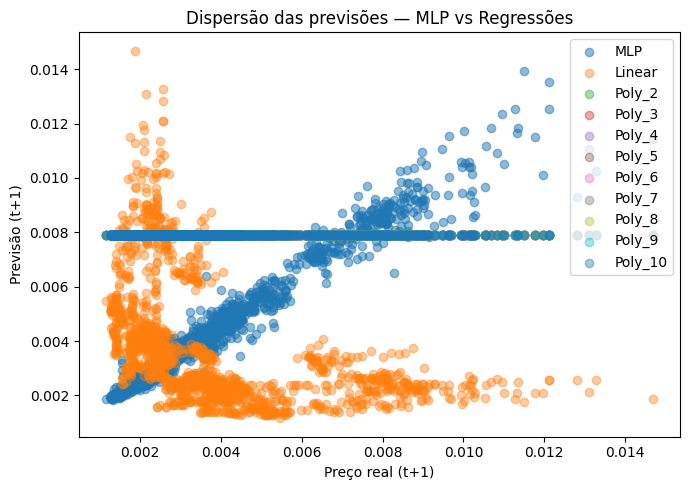

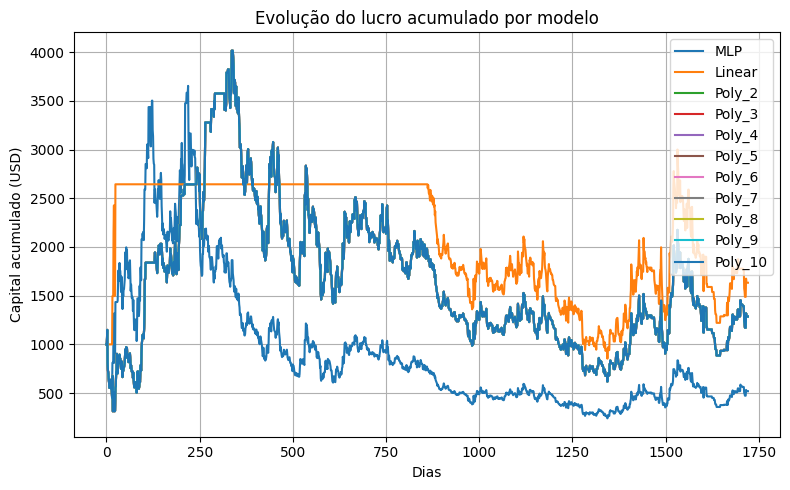

{'MLP': {'equity_curve': [1000.0, np.float64(999.9979838750324), np.float64(1148.5742972292394), np.float64(806.4298257463189), np.float64(731.0106229624536), np.float64(699.8050407156435), np.float64(654.1801327013452), np.float64(604.0935401339915), np.float64(554.3295275614362), np.float64(554.0553345658576), np.float64(636.3031526146115), np.float64(602.8475749040826), np.float64(584.6298696978431), np.float64(542.8013249973284), np.float64(542.8013249973284), np.float64(542.8013249973284), np.float64(811.8045063300716), np.float64(811.8045063300716), np.float64(811.8149409023547), np.float64(1171.25465233433), np.float64(1317.2499704317113), np.float64(1093.3762221002735), np.float64(811.8201581884961), np.float64(819.8234751295454), np.float64(1434.7536889104024), np.float64(1434.7536889104024), np.float64(1434.7536889104024), np.float64(1434.7536889104024), np.float64(1434.7536889104024), np.float64(1434.7536889104024), np.float64(1448.017529480443), np.float64(1602.893347240729

In [ ]:
df_new = pd.DataFrame()
df_new['close'] = y
X_aux = X.drop('date', axis=1)
scaler = StandardScaler()
df_new["mlp_pred"] = model.predict(scaler.fit_transform(X_aux))
df_new['lin_pred'] = modelo_lm.predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly2_pred'] = polynomial_model['modelo_2'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly3_pred'] = polynomial_model['modelo_3'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly4_pred'] = polynomial_model['modelo_4'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly5_pred'] = polynomial_model['modelo_5'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly6_pred'] = polynomial_model['modelo_6'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly7_pred'] = polynomial_model['modelo_7'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly8_pred'] = polynomial_model['modelo_8'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly9_pred'] = polynomial_model['modelo_9'].predict(polynomial_model['X'])[0:len(df_new)]
df_new['poly10_pred'] = polynomial_model['modelo_10'].predict(polynomial_model['X'])[0:len(df_new)]

regr_cols = {
    "Linear":   "lin_pred",
    **{f"Poly_{d}": f"poly{d}_pred" for d in range(2, 11)}
}

summary = backtest_and_compare(
    df_new,
    price_col="close",
    mlp_pred_col="mlp_pred",
    regr_pred_cols=regr_cols,
    init_capital=1_000.0
)

print(summary)

A tentativa de ajustar polinômios de alta ordem se mostrou ineficiente numericamente. Os modelos mais eficientes do ponto de precisão é a MLP, que com um nível de explicação de 80%, retornou a melhor curva de equity.

# **Testar se os retornos são positivos (5%)**

In [ ]:
from scipy import stats
import pandas as pd

def teste_retorno_positivo(df: pd.DataFrame, col_symbol: str, col_return: str, limite_pct: float = 0.01):
    """
    Testa H0: retorno_médio >= limite_pct vs H1: retorno_médio < limite_pct
    para cada criptomoeda no dataset.

    Parâmetros
    ----------
    df : DataFrame com colunas ['symbol', 'retorno']
    col_symbol : str — nome da coluna com símbolo (ex: 'AAVE/BTC')
    col_return : str — nome da coluna com retorno percentual (ou log-retorno)
    limite_pct : float — valor mínimo esperado para o retorno (ex: 0.01 = 1%)

    Retorno
    -------
    DataFrame com resultados: símbolo, média amostral, p-valor, rejeita_H0
    """
    resultados = []

    for simbolo, grupo in df.groupby(col_symbol):
        amostra = grupo[col_return].dropna().values
        n = len(amostra)
        if n < 5:
            continue  # ignora se tiver poucos dados

        media = amostra.mean()
        stderr = amostra.std(ddof=1) / n**0.5
        t_stat = (media - limite_pct) / stderr
        p_valor = stats.t.cdf(t_stat, df=n-1)  # unilateral à esquerda

        rejeita = p_valor < 0.05  # nível de significância de 5%

        resultados.append({
            "cripto": simbolo,
            "media_amostral": media,
            "p_valor": p_valor,
            "rejeita_H0": rejeita
        })

    return pd.DataFrame(resultados)

In [ ]:
moedas = ['AAVE', 'ADA', 'AERGO', 'AGLD', 'AKITA', 'ALPACA', 'ALPHA', 'APE', 'APX', 'ATLAS']
for count in range(1, 11):
    data = pd.read_csv(f"/content/drive/MyDrive/Trabalho Final IA/data/dataset0{count}.csv")
    df["ret"] = data["close"].pct_change()
    df["symbol"] = moedas[count-1]  # ou qualquer outra coluna se tiver múltiplas

    resultado_testes = teste_retorno_positivo(df, col_symbol="symbol", col_return="ret", limite_pct=0.005)

    print(resultado_testes)

  cripto  media_amostral   p_valor  rejeita_H0
0   AAVE        0.002054  0.020156        True
  cripto  media_amostral   p_valor  rejeita_H0
0    ADA        0.001888  0.000339        True
  cripto  media_amostral   p_valor  rejeita_H0
0  AERGO        0.002528  0.075321       False
  cripto  media_amostral   p_valor  rejeita_H0
0   AGLD        0.008061  0.836329       False
  cripto  media_amostral   p_valor  rejeita_H0
0  AKITA        0.009144  0.912301       False
   cripto  media_amostral   p_valor  rejeita_H0
0  ALPACA        0.638018  0.844955       False
  cripto  media_amostral   p_valor  rejeita_H0
0  ALPHA        0.007599  0.867514       False
  cripto  media_amostral   p_valor  rejeita_H0
0    APE        0.006378  0.713377       False
  cripto  media_amostral   p_valor  rejeita_H0
0    APX        0.022087  0.903012       False
  cripto  media_amostral   p_valor  rejeita_H0
0  ATLAS        0.014066  0.973982       False


# **ANOVA entre Criptomoedas**

In [ ]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def anova_criptos(df: pd.DataFrame, symbol_col: str, return_col: str):
    """
    Aplica ANOVA para verificar se o retorno médio diário difere entre criptos.

    Parâmetros:
    - df: DataFrame com colunas de símbolo e retorno
    - symbol_col: nome da coluna com o símbolo da cripto
    - return_col: nome da coluna com o retorno diário

    Retorno:
    - resultado ANOVA (F, p)
    - resultado do post-hoc Tukey (DataFrame), se p < 0.05
    """

    grupos = [g[return_col].dropna().values for _, g in df.groupby(symbol_col)]
    labels = df[symbol_col]

    f_stat, p_valor = stats.f_oneway(*grupos)

    print(f"ANOVA: F = {f_stat:.4f}, p = {p_valor:.4f}")

    posthoc = None
    if p_valor < 0.05:
        posthoc = pairwise_tukeyhsd(endog=df[return_col], groups=df[symbol_col], alpha=0.05)
        print(posthoc.summary())

    return f_stat, p_valor, posthoc


In [ ]:
from itertools import chain


symbol = []
retornos_moedas = []
moedas = ['AAVE', 'ADA', 'AERGO', 'AGLD', 'AKITA', 'ALPACA', 'ALPHA', 'APE', 'APX', 'ATLAS']
for count in range(1, 11):
    data1 = pd.read_csv(f"/content/drive/MyDrive/Trabalho Final IA/data/dataset0{count}.csv")
    retornos_moedas.append(data1["close"].pct_change().to_list())
    for ia in range(0, len(data1["close"].pct_change())):
        symbol.append(moedas[count-1])

flat_retornos = list(chain.from_iterable(retornos_moedas))

dados_recondicionado = {
    "symbol": symbol,
    "retorno": flat_retornos
}

dataframe_recondicionado = pd.DataFrame(dados)


f_stat, p_valor, posthoc = anova_criptos(dataframe_recondicionado, symbol_col="symbol", return_col="retorno")
print(resultado_testes)

ANOVA: F = 44.1000, p = 0.0003
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   BTC    ETH    0.015 0.0028  0.0071  0.0229   True
   BTC    SOL   -0.009 0.0302 -0.0169 -0.0011   True
   ETH    SOL   -0.024 0.0002 -0.0319 -0.0161   True
----------------------------------------------------
  cripto  media_amostral   p_valor  rejeita_H0
0  ATLAS        0.014066  0.973982       False


O teste Anova rejeitou a hipótese nula, mostrando que há diferença na média dos ganhos entre as moedas BTC - ETH, BTC - SOL e ETH - SOL.